[![Open In colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/DatosGeograficos/1_Introduccion/GeoPandas.ipynb)

# GeoPandas

I. Tabla de contenidos

    I. Tipos de datos geográficos
    II. Introducción a GeoPandas
        I. Importando datos
            I. GeoDataFrames: métodos y atributos
            II. Objetos geométricos
        II. Ejercicio
    III. Operaciones geográficas
        I. Mapeando hospitales
        II. Calculando la cobertura de los bomberos en CABA
        III. Ejercicios
        IV. Ejercicios opcionales
        V. Distancia aérea y centroide
        VI. Ejercicios

In [60]:
# !pip install geopandas

In [61]:
# !apt install libspatialindex-dev
# !pip install rtree

In [3]:
import pandas as pd
import geopandas
import shapely.wkt
import matplotlib.pyplot as plt
%matplotlib inline

## Tipos de datos geográficos

La información geográfica generalmente se agrupa en dos grandes categorías:

- Datos ráster
- Datos vectoriales

**Ráster**: Los datos ráster son aquellos donde la información se encuentra codificada sobre una grilla o red, donde cada celda (o píxel) presenta un valor numérico. Los datos ráster son usados comúnmente en imágenes satelitales, en este caso cada píxel representa un espacio definido por la granularidad o calidad de la imagen tomada, por ejemplo, un píxel puede representar una superficie de 30 metros por 30 metros.

Sin embargo, en esta clase nos vamos a concentrar en los datos **vectoriales**. En los datos vectoriales contamos con los siguientes tipos de objetos básicos: puntos, líneas, polígonos; así también tenemos multipunto, multilínea y multipolígono. La información se estructura a partir de las coordenadas de los vértices de cada uno de esos objetos.

## Introducción a GeoPandas
GeoPandas es la librería de Python por excelencia para el procesamiento de datos vectoriales. Provee fácil acceso a una serie de funcionalidades empleando diversas librerías:

- Manipulación de datos con Pandas.
- Lectura de archivos espaciales a través de Fiona.
- Objetos vectoriales y operaciones vectoriales con Shapely.
- Visualización de mapas con Descartes y Matplotlib.

### Importando datos

La datos vectoriales comúnmente se presenta en archivos como el formato shapefile (.shp) de ESRI, archivos GeoJSON, bases de PostGIS (es una extensión del motor de bases de datos PostgreSQL), etc.
Con la librería **GeoPandas** se pueden leer muchos de estos archivos, interfaceando con la librería GDAL/OGR, usando la función geopandas.read_file.
Además, también es posible leer información geográfica desde archivos planos (.csv) donde tenemos las coordenadas de puntos que referencian algún objeto. Por último, también existen casos en los que la información está guardada en formato WKT (Well-Known Text).

En esta notebook vamos a ver distintas formas de importar información geográfica de archivos vectoriales.

In [4]:
# https://data.buenosaires.gob.ar/dataset/barrios
barrios = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/barrios.csv", encoding='latin1')

In [5]:
barrios.head()

,WKT,BARRIO,COMUNA,PERIMETRO,AREA
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15.0,7725.695228,3.118101e+06
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,15.0,7087.513295,2.229829e+06
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15.0,8132.699348,3.613584e+06
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,5.0,8537.901368,4.050752e+06


In [ ]:
# En este caso la información está en WKT
barrios["WKT"].iloc[0]

#### GeoDataFrames: métodos y atributos

Los GeoDataFrame son objetos que tienen los mismos atributos que un Pandas DataFrame, con lo cual se puede manipular de datos a la que estamos acostumbrados. Como, por ejemplo, el método .plot(), acceso por .loc, .iloc, etc.
Además, los GeoDataFrames tienen un atributo *geometry* que indica la columna que contiene la información geográfica.

In [7]:
def from_wkt(df, wkt_column, crs='EPSG:4326'):
    
    df["coordinates"]= df[wkt_column].apply(shapely.wkt.loads) # empleamos una función de shapely para leer WKT
        
    gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=crs) # seteamos la columna de geometría
    
    return gdf

In [8]:
barrios = from_wkt(barrios, "WKT")

In [9]:
barrios.query("BARRIO == 'CABALLITO'") # podemos usar query

,WKT,BARRIO,COMUNA,PERIMETRO,AREA,coordinates
5,"POLYGON ((-58.4306058283309 -34.6070470885963,...",CABALLITO,6.0,10990.964471,6.851029e+06,"POLYGON ((-58.43061 -34.60705, -58.43056 -34.6..."


In [10]:
barrios[barrios['BARRIO']=='CABALLITO'] # podemos hacer boolean indexing

,WKT,BARRIO,COMUNA,PERIMETRO,AREA,coordinates
5,"POLYGON ((-58.4306058283309 -34.6070470885963,...",CABALLITO,6.0,10990.964471,6.851029e+06,"POLYGON ((-58.43061 -34.60705, -58.43056 -34.6..."


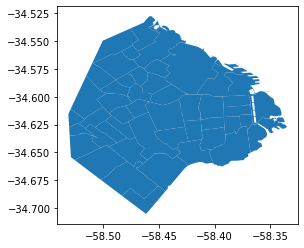

In [11]:
barrios.plot(); # BOOM: con uds. CABA!

A diferencia del Pandas DataFrame, tiene un atributo que mantiene la información de la geometría.

In [12]:
barrios.geometry.head() 

0    POLYGON ((-58.45282 -34.59599, -58.45366 -34.5...
1    POLYGON ((-58.46558 -34.59656, -58.46562 -34.5...
2    POLYGON ((-58.42375 -34.59783, -58.42495 -34.5...
3    POLYGON ((-58.49461 -34.61487, -58.49479 -34.6...
4    POLYGON ((-58.41287 -34.61412, -58.41282 -34.6...
Name: coordinates, dtype: geometry

Noten que cada barrio es un polígono

In [13]:
barrios.crs = "EPSG:4326" # seteamos el 'coordinate reference system', EPSG 4326 equivale a WGS 84

#### Objetos geométricos

La librería shapely nos provee acceso a los objetos geométricos. Con ella podemos generar los objetos Point, Polygon y Line. Veamos un ejemplo.

Además, podemos especificar la proyección pasando el parámetro crs. Para ver cómo transformar una proyección se puede ir a: http://geopandas.readthedocs.io/en/latest/projections.html

In [14]:
from shapely.geometry import Point

p = Point(-58.396295, -34.591789) # Armo un punto a partir de dos coordenadas geográficas

df = pd.DataFrame(data = {'id': [1]}) # Armo un DataFrame

gdf = geopandas.GeoDataFrame(df, crs="EPSG:4326", geometry=[p])

In [15]:
gdf # este es un GeoDataFrame con un solo punto

,id,geometry
0,1,POINT (-58.39630 -34.59179)


Matplotlib funciona graficando capas. Para poder asociar distintas capas a un mismo gráfico es necesario instanciar un objeto AxesSubplot al cual referenciar.

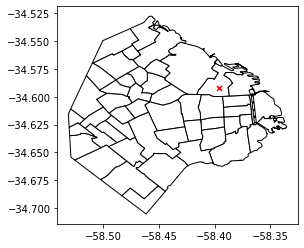

In [16]:
fig, ax = plt.subplots() # Noten que vamos a reutilizar el axis (ax) en cada plot. 
ax.set_aspect('equal')
barrios.plot(ax=ax, color='white', edgecolor='black') # Esto es para evitar que las capas se ploteen separadas.
gdf.plot(ax=ax, marker='x', color='red', markersize=25)
plt.show();

In [ ]:
type(ax)

Si quisiéramos podemos cambiar la proyección empleando el método .to_crs()

Ahora hagamos un plot de uno solo de los barrios, habiendo reproyectado el mapa.

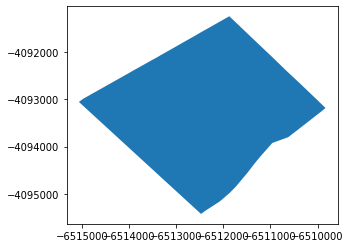

In [17]:
palermo = barrios[barrios["BARRIO"] == "MATADEROS"]
palermo.to_crs(epsg = 3395).plot() #EPSG 3395 es World Mercator. Noten los valores de los ejes, qué distintos son a 4326

### Ejercicio
1- En Google Maps buscar un punto en el barrio de Mataderos y guardar las coordenadas

2- Graficar el barrio junto al punto en EPSG 3395. Antes, piensen bien qué proyección usa Google Maps.

## Operaciones geográficas

En geopandas tenemos distintos métodos para realizar diferentes operaciones geográficas:
    - equals
    - contains
    - crosses
    - disjoint
    - overlaps
    - touches
    - within
    - covers
    - contains
    - intersects
    - intersection
    - union
    - unary_union
    - difference
    - overlay (difference, intersection, symmetric_difference) 
    - sjoin
    
    
En el siguiente link se tiene una referencia de varios de estos métodos, los heredados de shapely:
https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships

### Mapeando hospitales

In [18]:
# https://data.buenosaires.gob.ar/dataset/hospitales

In [19]:
hospitales = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/hospitales.csv")

In [ ]:
hospitales

Nótese que en este caso la información no viene en WKT sino que contamos con una columna long y una columna lat. Vamos a ver cómo construir manualmente un punto, y luego vamos a iterar por cada fila construyendo el punto de cada hospital.

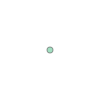

In [21]:
import numpy as np
Point((1, 1))

In [22]:
def from_x_y(df, x, y, crs='EPSG:4326'):
    gdf = geopandas.GeoDataFrame(df.drop([x, y], axis=1), # eliminamos las columnas originales
                                crs=crs, # Agregamos CRS
                                geometry=geopandas.points_from_xy(df[x], df[y])) # junto "x" e "y" y lo paso a Point
    return gdf

In [23]:
hospitales = from_x_y(hospitales, "long", "lat")

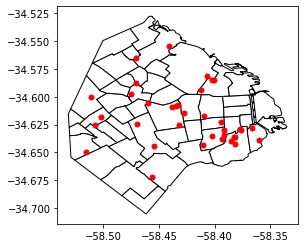

In [24]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios.plot(ax=ax, color='white', edgecolor='black')
hospitales.plot(ax=ax, color='red', markersize=25)
plt.show();

Tomemos dos hospitales y grafiquemos una línea entre ambos puntos:

In [25]:
hospital_a = hospitales.loc[0, "geometry"]

In [26]:
hospital_b = hospitales.loc[1, "geometry"]

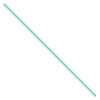

In [27]:
from shapely.geometry import LineString # Objeto línea

linea = LineString([hospital_a, hospital_b])
linea

geopandas.geoseries.GeoSeries

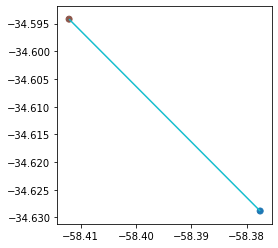

In [28]:
puntos_y_linea = geopandas.GeoSeries([hospital_a, hospital_b, linea]) # Noten que estamos guardando dos puntos y una línea
puntos_y_linea.plot(cmap='tab10'); # ploteo todo
type(puntos_y_linea)

In [29]:
barrio = barrios.loc[barrios["BARRIO"]=="BARRACAS"]

Con el método **GeoDataFrame.contains** podemos ver si un polígono contiene un punto.

In [30]:
barrio.contains(hospital_a)

29    True
dtype: bool

In [31]:
barrio.contains(hospital_b)

29    False
dtype: bool

Con el método **GeoDataFrame.crosses** podemos ver si una geometría corta otra. En este caso, para cada barrio podemos ver si se corta con la línea marcada entre los dos hospitales.

In [32]:
barrios.head().crosses(linea)

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [33]:
barrios[barrios.crosses(linea)].BARRIO

11    CONSTITUCION
24       BALVANERA
29        BARRACAS
41       MONSERRAT
44        RECOLETA
Name: BARRIO, dtype: object

### Calculando la cobertura de los bomberos en CABA

In [34]:
# https://data.buenosaires.gob.ar/dataset/cuarteles-destacamentos-bomberos
bomberos = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/bomberos.csv")
bomberos.head(3)

,id,long,lat,dcia,tipo,cuartel,gestion,calle_ofic,inters,altura,direcci,tel,barrio,comuna,codigo_postal,codigo_postal_argentino,observacion
0,1,-58.435809,-34.577526,DESTACAMENTO PALERMO,DESTACAMENTO,NaN,Policía de la Ciudad,GUATEMALA,NaN,5966,5966 GUATEMALA,4772-2222,Palermo,Comuna 14,1425,C1425BVP,NaN
1,2,-58.487654,-34.644895,DESTACAMENTO VELEZ SARSFIELD,DESTACAMENTO,NaN,Policía de la Ciudad,RODO JOSE E.,NaN,4474,4474 RODO JOSE E.,4671-2222,Parque Avellaneda,Comuna 9,1407,C1407HDR,Brigada Especial Federal De Rescate (BEFER)
2,3,-58.435415,-34.630275,DESTACAMENTO GER CABALLITO,DESTACAMENTO,NaN,Policía de la Ciudad,RIGLOS,NaN,959,959 RIGLOS,4921-2737,Parque Chacabuco,Comuna 7,1424,C1424AFS,Brigada Especial Federal De Rescate (BEFER)


In [35]:
bomberos = from_x_y(bomberos, "long","lat")

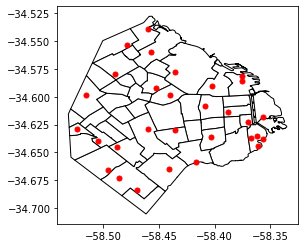

In [36]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios.plot(ax=ax, color='white', edgecolor='black')
bomberos.plot(ax=ax, marker='o', color='red', markersize=25)
plt.show();

Imagínese que se desea bacer el siguiente análisis: suponiendo que cada delegación de bomberos tiene un alcance de hasta 1.5 km (ACLARACIÓN: este valor no se basa en la realidad) se desean obtener los lugares abarcados y los no abarcados por el servicio.

Para ello primero tendremos que convertir la proyección a una proyección que nos permita trabajar en metros y no en grados. Para eso usaremos la proyección  Gauss-Krueger Buenos Aires. 

Para obtener los datos de proyección se puede entrar a http://spatialreference.org/

Convertimos nuestros datasets a GKBA

In [37]:
barrios_gkba = barrios.to_crs(crs = "+proj=tmerc +lat_0=-34.629269 +lon_0=-58.4633 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs")

In [38]:
bomberos_gkba = bomberos.to_crs(crs = "+proj=tmerc +lat_0=-34.629269 +lon_0=-58.4633 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs")

Veamos cómo son los valores de la geometría ahora...

In [39]:
bomberos_gkba.head().geometry

0    POINT (102522.494 105739.771)
1      POINT (97767.105 98266.211)
2     POINT (102557.088 99887.991)
3     POINT (98539.106 108425.610)
4    POINT (106892.933 101766.659)
Name: geometry, dtype: geometry

Armamos un buffer de 1500 metros alrededor de cada cuartel y delegación de bomberos.

In [40]:
bomberos_gkba_buff = bomberos_gkba.copy()
bomberos_gkba_buff.geometry = bomberos_gkba.buffer(1500)

Vamos a plotear el área cubierta por los bomberos...

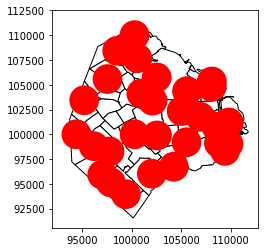

In [41]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios_gkba.plot(ax=ax, color='white', edgecolor='black')
bomberos_gkba_buff.plot(ax=ax, color='red')
plt.show();

Ahora vamos a ver cómo calcular el área cubierta y el área no cubierta. El área cubierta es la **intersección** entre la capa de barrios y la capa de bomberos (con su buffer). Por otro lado, el área no cubierta es la **diferencia** entre la capa de barrios y la capa de bomberos (con su buffer).

In [42]:
interseccion = geopandas.overlay(bomberos_gkba_buff, barrios_gkba, how = "intersection")

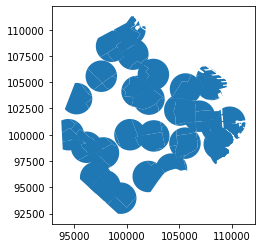

In [43]:
interseccion.plot();

Los GeoDataFrame tienen un atributo con el valor del área ya calculada para cada polígono, veámoslo:

In [44]:
interseccion.head().area

0    4.856944e+05
1    9.135930e+05
2    3.073288e+06
3    1.162122e+06
4    6.557971e+05
dtype: float64

Sin embargo, como podemos ver en la figura anterior, hay superposición entre los polígonos, con lo cual estaría doblecontabilizando parte del área. Para poder tener un buen cálculo del área primero debemos unir todos los polígonos en uno solo, de esa manera estaremos resolviendo la duplicación.

Para poder hacer eso vamos a tener que emplear **dissolve**. Esta función junta geometrías dentro de una columna que se usa para agrupar. Por ejemplo, si quisiéramos calcular el área cubierta por barrio. Sin embargo, en nuestro caso queremos juntar todas las geometrías en una sola. Para ello usaremos un truco, construiremos una columna "constante" y la usaremos para "agrupar". Nota: es obligatorio pasar una columna de agrupamiento, si no fuera así no sería necesario este "truco".

In [45]:
interseccion["const"] = 0

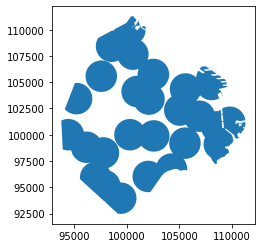

In [46]:
interseccion.dissolve(by="const").plot() # los barrios agrupados

In [47]:
print("La cantidad total de metros que están cubiertos por bomberos es:", 
      round(interseccion.dissolve(by="const").area.sum()))

La cantidad total de metros que están cubiertos por bomberos es: 141080651.0


Ahora calculemos el área no cubierta por el servicio, con el mismo procedimiento que antes pero empleando **difference**.

In [48]:
diferencia = geopandas.overlay(barrios_gkba, bomberos_gkba_buff, how = "difference")

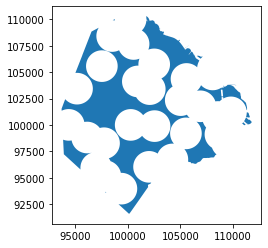

In [49]:
diferencia["const"] = 0
diferencia.dissolve(by="const").plot() # los barrios agrupados

In [50]:
print("La cantidad total de metros que no están cubiertos por bomberos es:", 
      diferencia.dissolve(by="const").area.sum())

La cantidad total de metros que no están cubiertos por bomberos es: 62191574.9743366


Ahora, veamos con qué precisión estamos haciendo nuestro calculo. Vamos a ver la diferencia entre las áreas computadas y el total de área en Buenos Aires.

In [51]:
diferencia.dissolve(by="const").area.sum() + interseccion.dissolve(by="const").area.sum()

203272225.9202038

In [52]:
barrios_gkba.area.sum()

203272225.92020506

### Ejercicios

1- Calcule **cuántos metros** cuadrados de FLORES tienen cobertura por el servicio de bomberos.

2- Calcule qué **porcentaje** de FLORES tiene cobertura por el servicio de bomberos.

### Ejercicios opcionales

1- Empleando la función overlay realizar una unión entre barrios_gkba y bomberos_gkba_buff y graficar, interpretar lo obtenido.

2- Empleando la función overlay realizar una diferencia entre barrios_gkba y bomberos_gkba_buff (como hicimos antes) y graficar, y comparar con un gráfico de la diferencia simétrica. Comparar ambos casos.

3- Un atributo de los GeoDataFrame es la frontera, la cual se puede acceder desde .boundary. Probar el método con un gráfico.

### Distancia aérea y centroide

Otro uso muy común en operaciones geográficas, especialmente cuando hacemos análisis urbanos, es el cálculo de una **distancia**. Por simplicidad en este caso vamos a calcular la distancia aérea (o distancia euclidea). 

En ciertos casos es necesario tener una mayor precisión, para lo cual necesitamos calcular las distancias basándonos en el callejero de la ciudad y, en ocasiones, en los sentidos de las calles (si la distancia a recorrer es en un auto, o camión).

Por otra parte, para representar el centro de un polígono usamos el concepto de **centroide**.

Supongamos que se desea conocer cuáles son las 3 delegaciones de bomberos más cercanas al centro de Palermo, para ello podemos:
    - Calcular el centroide
    - Calcula la distancia a todos los centros de bomberos
    - Quedarnos con los tres más cercanos

In [53]:
palermo = barrios_gkba[barrios_gkba["BARRIO"] == "PALERMO"].copy()
caballito = barrios_gkba[barrios_gkba["BARRIO"] == "CABALLITO"].copy()
centroid = palermo.centroid

In [54]:
caballito_centroide = caballito.centroid # vean que el centroide es una geoserie con un punto
palermo_centroide = palermo.centroid
palermo_centroide

33    POINT (103749.893 106141.469)
dtype: geometry

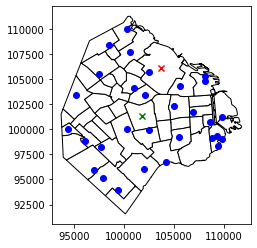

In [55]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios_gkba.plot(ax=ax, color='white', edgecolor='black')
caballito_centroide.plot(ax=ax, marker="x", color='green')
palermo_centroide.plot(ax=ax, marker="x", color='red')
bomberos_gkba.plot(ax=ax, color='blue')
plt.show();

In [56]:
centroide = caballito_centroide.iloc[0] # nos quedamos sólo con el valor (que es un Point)

In [57]:
mas_cercanos = bomberos_gkba.geometry.apply(lambda x: x.distance(centroide)).nsmallest(3).index

In [58]:
mas_cercanos = bomberos_gkba.loc[mas_cercanos]

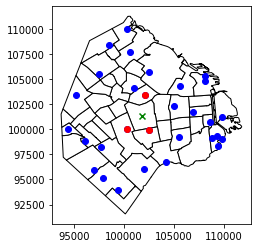

In [59]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios_gkba.plot(ax=ax, color='white', edgecolor='black')
caballito_centroide.plot(ax=ax, marker="x", color='green')
bomberos_gkba.plot(ax=ax, color='blue') # esta capa tiene TODAS las delegaciones de bomberos
mas_cercanos.plot(ax=ax, color='red') # esta capa tiene sólo las 3 delegaciones más cercanas y pisa la capa anterior
plt.show();

### Ejercicios

1- Imaginemos que hay un incendio en Recoleta y un incendio en Monte Castro. Por conveniencia tomemos el centroide de cada barrio.

2- El gobierno decide ocupar las delegaciones de los bomberos según la proximidad, es decir, debemos asignar cada de delegación al incendio más cercano. Entonces, decida a qué incendio se va a enfocar cada delegación.